##### Working ipynb for explainability in machine learning 

- main goal is to delineate model explainability between Shap, Lime and GAM
- This will act as a shell file on the Austrailian Credit Approval Data until Cap One data is readily available

Imports. Clean up later

In [1]:
from __future__ import print_function
from helpful_util import *
from heaton_utils import *

import seaborn as sns
import pandas_profiling
from pylab import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

import sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

#!pip install livelossplot
from livelossplot import PlotLossesKeras
from tensorflow.python.client import device_lib
from keras.losses import binary_crossentropy

from heaton_utils import *

import os
import sys
import glob
#pip install counter

import pickle
import sklearn

import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Flatten, Dense, Input
from keras.utils import layer_utils
from keras import backend as K
from keras.engine.topology import get_source_inputs
from keras.models import load_model
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.optimizers import SGD, adam, adamax, Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, ReLU, ELU
from keras.losses import binary_crossentropy


device_lib.list_local_devices() #See available devices. If Running a Keras model, session to GPU

#files, main_dir = list_dir()
#main_dir

Using TensorFlow backend.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6424531477731664425, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6590074061
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16599779311591658573
 physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 6700198133
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6742859724531281591
 physical_device_desc: "device: 1, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1"]

In [2]:
#files, main_dir = list_dir()
#main_dir
list_dir()[1] #List contents of working Dir

Working Dir: C:\Users\jdine\Documents\1.MachineLearning\hicss2020-master
Returning Contents of Working Directory..


{0: '.git',
 1: '.gitignore',
 2: '.ipynb_checkpoints',
 3: 'AustralianCreditApproval.ipynb',
 4: 'data',
 5: 'heaton_utils.py',
 6: 'helpful_util.py',
 7: 'LICENSE',
 8: 'logs',
 9: 'models',
 10: 'model_weights',
 11: 'README.md',
 12: 'temp_model.py',
 13: '__pycache__'}

In [3]:
#Clean Data
df = load_data(path='data',
               drop_outliers=True, #Tukey Method
               columns=16, #including index
               outlier_columns=['A7', 'A2', 'A14', 'A13']) #Only remove outliers on non-discrete features

Choose a file from data directory:
0) australian.dat
1) australian.doc
2) ~$stralian.doc
Enter Number: 0
Path to Data Stored: C:\Users\jdine\Documents\1.MachineLearning\hicss2020-master\data\australian.dat


In [88]:
pandas_profiling.ProfileReport(df) #Neat tool for quick EDA

Number of variables,16
Number of observations,662
Total Missing (%),0.0%
Total size in memory,82.8 KiB
Average record size in memory,128.1 B
Numeric,11
Categorical,0
Boolean,5
Date,0
Text (Unique),0
Rejected,0


In [12]:
#g = sns.heatmap(df.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [8]:
X_train, X_test, y_train, y_test = split_data(df=df,
                                              keras=False,
                                              testSize=0.2,
                                              randomState=123)

#Get Shape of train / test sets.
data = [X_train, X_test, y_train, y_test]
data_list = ["X_train", "X_test", "y_train", "y_test"]
for i in range(4):
    print(data_list[i], "Shape:")
    print(data[i].shape)

X_train Shape:
(529, 14)
X_test Shape:
(133, 14)
y_train Shape:
(529,)
y_test Shape:
(133,)


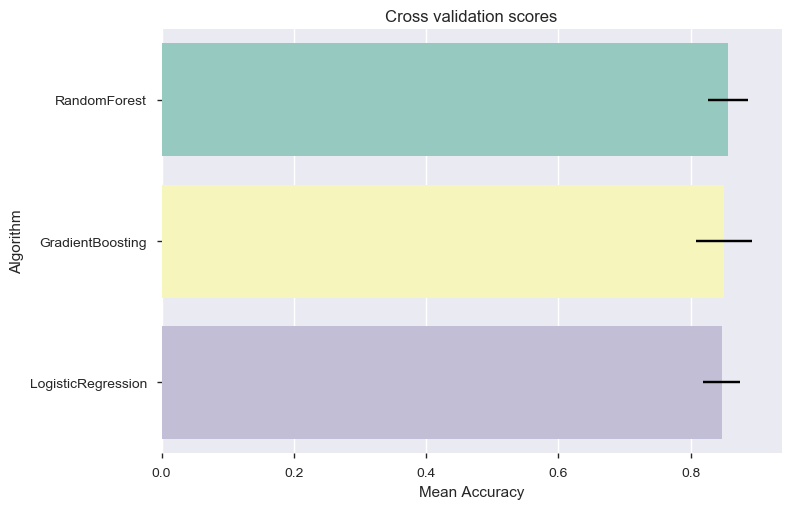

In [92]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=5)

#Run Kfold CrossVal on base classifiers

random_state = 1
classifiers = []
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(LogisticRegression(random_state=random_state))

cv_results = []
for classifier in classifiers:
    cv_results.append(
        cross_val_score(classifier,
                        X_train,
                        y=y_train,
                        scoring="accuracy",
                        cv=kfold,
                        n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({
    "CrossValMeans":
    cv_means,
    "CrossValerrors":
    cv_std,
    "Algorithm": ["RandomForest", "GradientBoosting", "LogisticRegression"]
})

g = sns.barplot("CrossValMeans",
                "Algorithm",
                data=cv_res,
                palette="Set3",
                orient="h",
                **{'xerr': cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [93]:
#Grid Search parameter space.

# RFC Parameters tunning
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {
    "n_estimators": [10, 20, 50, 100],
    "max_depth": [None],
    "max_features": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
    "min_samples_split": [2, 3, 10, 25, 50],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [False],
    "n_estimators": [100, 300, 500, 1000],
    "criterion": ["gini"]
}

gsRFC = GridSearchCV(RFC,
                     param_grid=rf_param_grid,
                     cv=kfold,
                     scoring="accuracy",
                     n_jobs=6,
                     verbose=1)
gsRFC.fit(X_train, y_train)

# Gradient boosting tunning
GBC = GradientBoostingClassifier()
gb_param_grid = {
    'loss': ["deviance", "exponential"],
    'n_estimators': [100, 200, 300, 500, 1000],
    'learning_rate': [0.1, 0.05, 0.01, .001],
    'max_depth': [4, 8],
    'min_samples_leaf': [100, 150],
    'max_features': ["auto", "sqrt", "log2", None]
}

gsGBC = GridSearchCV(GBC,
                     param_grid=gb_param_grid,
                     cv=kfold,
                     scoring="accuracy",
                     n_jobs=6,
                     verbose=1)
gsGBC.fit(X_train, y_train)

#Sklearn Logit Regression Tuning
LR = LogisticRegression()
LR_param_grid = {'penalty': ['l1', 'l2']}

gsLR = GridSearchCV(LR,
                    param_grid=LR_param_grid,
                    cv=kfold,
                    scoring="accuracy",
                    n_jobs=6,
                    verbose=1)
gsLR.fit(X_train, y_train)

# Best score
print("\033[1mPrinting Best Cross Validation Accuracy.... \033[0m")
print("RF Best Score: {0:.2f} %".format(gsRFC.best_score_ * 100))
print("GBC Best Score: {0:.2f} %".format(gsGBC.best_score_ * 100))
print("Logit Best Score: {0:.2f} %".format(gsLR.best_score_ * 100))

Fitting 5 folds for each of 840 candidates, totalling 4200 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 100 tasks      | elapsed:    6.9s
[Parallel(n_jobs=6)]: Done 402 tasks      | elapsed:   25.7s
[Parallel(n_jobs=6)]: Done 778 tasks      | elapsed:   51.5s
[Parallel(n_jobs=6)]: Done 1128 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 1578 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 2128 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 2778 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 3528 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 4200 out of 4200 | elapsed:  6.4min finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 5 folds for each of 640 candidates, totalling 3200 fits


[Parallel(n_jobs=6)]: Done 220 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done 852 tasks      | elapsed:   17.3s
[Parallel(n_jobs=6)]: Done 1852 tasks      | elapsed:   37.6s


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Printing Best Cross Validation Accuracy.... 
RF Best Score: 86.96 %
GBC Best Score: 86.20 %
Logit Best Score: 85.63 %


[Parallel(n_jobs=6)]: Done 3200 out of 3200 | elapsed:  1.1min finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


In [94]:
#Visualizing hyper params of best models + dumping best models to pkl

print("Viewing Model Parameters:\n")
print(gsRFC.best_estimator_)
print(gsGBC.best_estimator_)
print(gsLR.best_estimator_)

import pickle
from sklearn.externals import joblib

print("Serializing Best Models\n")
rf_file = "models\\random_forest.pkl"
joblib.dump(gsRFC.best_estimator_, rf_file)

gbc_file = "models\\GBC.pkl"
joblib.dump(gsGBC.best_estimator_, gbc_file)

logit_file = "models\\Logit.pkl"
joblib.dump(gsLR.best_estimator_, logit_file)
#Note - Outliers were removed, but no features were scaled / normalized.

Viewing Model Parameters:

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=100, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
L

['models\\Logit.pkl']

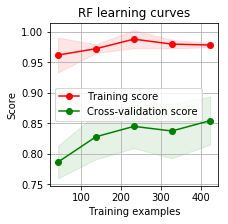

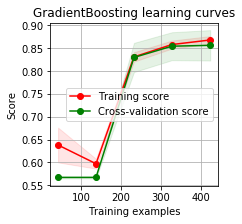

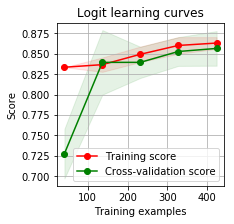

In [10]:
from sklearn.externals import joblib
rcParams['figure.figsize'] = 3, 3  #Adjust plot size
kfold = StratifiedKFold(n_splits=5)
rf_file = "models\\random_forest.pkl"
gbc_file = "models\\GBC.pkl"
logit_file = "models\\Logit.pkl"
#fetch saved models
rfc = joblib.load(rf_file)
gbc = joblib.load(gbc_file)
logit = joblib.load(logit_file)

#Learning Curve. Works better w. more data.
#Visualizes how estimators perform given more data
g = plot_learning_curve(rfc, "RF learning curves", X_train, y_train, cv=kfold)
g = plot_learning_curve(gbc,
                        "GradientBoosting learning curves",
                        X_train,
                        y_train,
                        cv=kfold)
g = plot_learning_curve(logit,
                        "Logit learning curves",
                        X_train,
                        y_train,
                        cv=kfold)

Printing Test Accuracy.... 
Random Forest: 87.22 %
Gradient Boosting: 90.98 %
Logistic Regression: 90.23 % 
 

 Random Forest Classification Report...
 
              precision    recall  f1-score   support

           0       0.89      0.90      0.90        81
           1       0.84      0.83      0.83        52

   micro avg       0.87      0.87      0.87       133
   macro avg       0.87      0.86      0.87       133
weighted avg       0.87      0.87      0.87       133



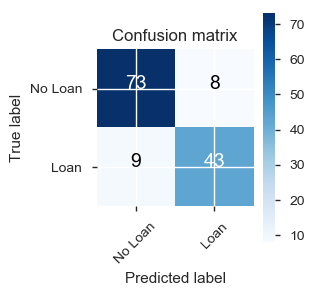

 Gradient Boosting Classification Report...
 
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        81
           1       0.88      0.88      0.88        52

   micro avg       0.91      0.91      0.91       133
   macro avg       0.91      0.91      0.91       133
weighted avg       0.91      0.91      0.91       133



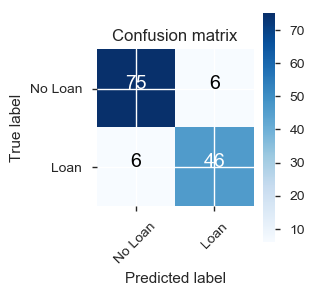

 Logistic Regression Classification Report...
 
              precision    recall  f1-score   support

           0       0.95      0.89      0.92        81
           1       0.84      0.92      0.88        52

   micro avg       0.90      0.90      0.90       133
   macro avg       0.89      0.91      0.90       133
weighted avg       0.91      0.90      0.90       133



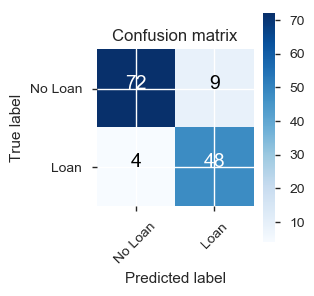

In [97]:
#Some classification Reports and Confusion Matrices
from sklearn.metrics import confusion_matrix, classification_report

#gsRFC.best_estimator_.predict(X_test)
#gsGBC.best_estimator_.predict(X_test)
#gsLR.best_estimator_.predict(X_test)
class_names = ['No Loan', 'Loan']

rf_best_score = sklearn.metrics.accuracy_score(
    y_test, gsRFC.best_estimator_.predict(X_test))
gbc_best_score = sklearn.metrics.accuracy_score(
    y_test, gsGBC.best_estimator_.predict(X_test))
lr_best_score = sklearn.metrics.accuracy_score(
    y_test, gsLR.best_estimator_.predict(X_test))

print("\033[1mPrinting Test Accuracy.... \033[0m")
print("Random Forest: {0:.2f} %".format(rf_best_score * 100))
print("Gradient Boosting: {0:.2f} %".format(gbc_best_score * 100))
print("Logistic Regression: {0:.2f} % \n \n".format(lr_best_score * 100))

rcParams['figure.figsize'] = 3, 3  #Adjust plot size

print("\033[1m Random Forest Classification Report...\n \033[0m")
print(classification_report(y_test, gsRFC.best_estimator_.predict(X_test)))
cm = confusion_matrix(y_test, gsRFC.best_estimator_.predict(X_test))
plot_confusion_matrix(cm, classes=class_names)
plt.show()

print("\033[1m Gradient Boosting Classification Report...\n \033[0m")
print(classification_report(y_test, gsGBC.best_estimator_.predict(X_test)))
cm = confusion_matrix(y_test, gsGBC.best_estimator_.predict(X_test))
plot_confusion_matrix(cm, classes=class_names)
plt.show()

print("\033[1m Logistic Regression Classification Report...\n \033[0m")
print(classification_report(y_test, gsLR.best_estimator_.predict(X_test)))
cm = confusion_matrix(y_test, gsLR.best_estimator_.predict(X_test))
plot_confusion_matrix(cm, classes=class_names)
plt.show()

### Deep Learning 
Building an MLP. Using Hyperas for hyperparameter search.

- Note that we are scaling a few features here - Logit/GBC/RF were trained w/ no such cleaning.


In [2]:
#This ends up being unnecessary. We don't need OHE encoding of cat var for Keras wrapper on SKlearn for hyperparameter search

##Using Heaton's Utils
#Built in OHE of explanatory
#!pip install requests
#Use this if we want to OHE dependent var
#df = load_data(path = 'data', drop_outliers = False, columns = 16, outlier_columns= ['A7', 'A2','A14', 'A13'])

#X_train, X_test, y_train, y_test = split_data(df = df, keras = False, testSize = 0.2, randomState = 123)

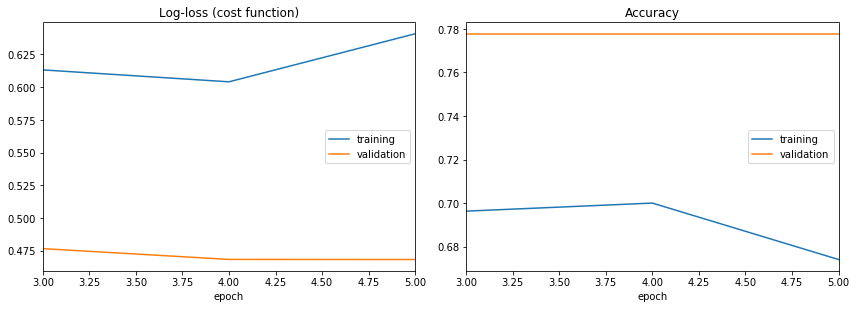

Log-loss (cost function):                                                                                                                                                       
training   (min:    0.604, max:    0.737, cur:    0.641)
validation (min:    0.468, max:    0.496, cur:    0.468)

Accuracy:
training   (min:    0.594, max:    0.700, cur:    0.674)
validation (min:    0.778, max:    0.785, cur:    0.778)
Best validation acc of epoch:                                                                                                                                                   
0.785185186068217                                                                                                                                                               
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.66s/it, best loss: -0.7888888902134366]
Evalutation of best performing model:
135/135 [======

In [4]:
import numpy as np
from keras.utils import multi_gpu_model
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
import time


def data():
    df = load_data_gridsearch(
        columns=16,  #including index
        outlier_columns=['A2', 'A3', 'A13', 'A14'], 
        scale_columns=['A2', 'A3', 'A13', 'A14']) # Min Max scaling of features with poisson- like distributions

    X_train, X_test, y_train, y_test = split_data(df=df,
                                                  keras=True, #sets in fp 32 precision with OHE of Response
                                                  testSize=0.2, 
                                                  randomState=123)
    return X_train, X_test, y_train, y_test


def create_model(x_train, y_train, x_test, y_test):
    #Keras Callbacks
    #early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
    #                                               min_delta=0,
    #                                               patience=50,
    #                                               verbose=1,
    #                                               mode='auto')
    #MCP = keras.callbacks.ModelCheckpoint("C:\\Users\\jdine\\Documents\\1.MachineLearning\\hicss2020-master\\model_weights\\best_model.h5",
    #                                      monitor='val_loss', mode='min', verbose=1, save_best_only= True)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=5,
                                                  min_lr=0.001)
    #tensorboard = keras.callbacks.TensorBoard(
    #    log_dir="logs\\")

    model = Sequential()
    model.add(Dense({{choice([32, 64, 128])}}, input_shape=(14, )))
    model.add(
        Activation({{choice(['relu', 'sigmoid', 'tanh', 'elu', 'selu'])}}))
    model.add(Dropout({{uniform(0.2, 1)}}))
    model.add(BatchNormalization(momentum={{uniform(0, 1)}}))
    model.add(Dense({{choice([32, 64, 128])}}))
    model.add(
        Activation({{choice(['relu', 'sigmoid', 'tanh', 'elu', 'selu'])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(BatchNormalization())

    # If we choose 'four', add an additional fourth layer
    if {{choice(['three', 'four'])}} == 'four':
        model.add(Dense({{choice([32, 64, 128])}}))
        model.add(
            Activation({{choice(['relu', 'sigmoid', 'tanh', 'elu', 'selu'])}}))
        model.add(Dropout({{uniform(0, 1)}}))
        model.add(BatchNormalization())
    if {{choice(['four', 'five'])}} == 'five':
        model.add(
            Activation({{choice(['relu', 'sigmoid', 'tanh', 'elu', 'selu'])}}))
        model.add(Dense({{choice([32, 64, 128])}}))
        model.add(Dropout({{uniform(0, 1)}}))
        model.add(BatchNormalization())

    model.add(Dense(2))
    model.add(Activation('sigmoid'))
    model = multi_gpu_model(model, gpus=2)
    model.compile(loss='binary_crossentropy',
                           optimizer={{
                               choice([
                                   'rmsprop', 'adam', 'sgd', 'adagrad',
                                   'adadelta', 'adamax', 'nadam'
                               ])
                           }},
                           metrics=['accuracy'])
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                            log_device_placement=True))
    result = model.fit(X_train, y_train, batch_size= {{choice([32,64, 128])}},
                       epochs={{choice([5])}}, verbose=2,\
                            validation_split= .25, callbacks=[PlotLossesKeras(), reduce_lr])

    #get the highest validation accuracy of the training epochs
    validation_acc = np.amax(result.history['val_acc'])
    print('Best validation acc of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}


best_run, best_model = optim.minimize(model=create_model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=5,
                                      trials=Trials(),
                                      notebook_name='AustralianCreditApproval',
                                      eval_space=True)

X_train, X_test, y_train, y_test = data()
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

In [43]:
ypred = np.argmax(best_model.predict(X_test), axis = 1)
ytest = np.argmax(y_test, axis = 1)

sklearn.metrics.accuracy_score(ytest, ypred)

0.8074074074074075